In [1]:
%matplotlib notebook

import sys
import os
import time

In [2]:
import numpy as np
import qcodes as qc
import broadbean as bb

from matplotlib import pyplot as plt
from broadbean.plotting import plotter

from pytopo.mplplots.init_nb_plotting import *
from pytopo.mplplots import plots as mplplots
from pytopo.mplplots import tools as mpltools

# Initialization

## Classes and methods

## Load Instruments

In [3]:
from pytopo.qctools import instruments as instools
from pytopo.rf.alazar_acquisition import RawAcqCtl, DemodAcqCtl, DemodRelAcqCtl, IQAcqCtl, IQRelAcqCtl

inst_list = []

from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = instools.create_inst(AlazarTech_ATS9360, 'alazar')
inst_list.append(alazar)

raw_acq = instools.create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
inst_list.append(raw_acq)

demod_acq = instools.create_inst(DemodAcqCtl, 'demod_acq', 'alazar', force_new_instance=True)
inst_list.append(demod_acq)

demodrel_acq = instools.create_inst(DemodRelAcqCtl, 'rel_acq', 'alazar', force_new_instance=True)
inst_list.append(demodrel_acq)

iqrel_acq = instools.create_inst(IQRelAcqCtl, 'iqrel_acq', 'alazar', force_new_instance=True)
inst_list.append(iqrel_acq)

iq_acq = instools.create_inst(IQAcqCtl, 'iq_acq', 'alazar', force_new_instance=True)
inst_list.append(iq_acq)

from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
awg5014 = instools.create_inst(Tektronix_AWG5014, 'awg5014', address="TCPIP0::169.254.220.147::inst0::INSTR")
inst_list.append(awg5014)

from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.2.20")
inst_list.append(LO)
RF = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.231.38")
inst_list.append(RF)

station = qc.Station(*inst_list)

Connected to: TEKTRONIX AWG5014C (serial:B051389, firmware:SCPI:99.0 FW:4.6.0.7) in 0.16s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110509, firmware:3.1.19.15-3.50.124.67) in 0.04s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110510, firmware:3.1.19.15-3.50.124.67) in 0.04s


Snapshot: Could not update parameter:clock_source
Snapshot: Could not update parameter:external_sample_rate
Snapshot: Could not update parameter:sample_rate
Snapshot: Could not update parameter:clock_edge
Snapshot: Could not update parameter:decimation
Snapshot: Could not update parameter:coupling1
Snapshot: Could not update parameter:channel_range1
Snapshot: Could not update parameter:impedance1
Snapshot: Could not update parameter:coupling2
Snapshot: Could not update parameter:channel_range2
Snapshot: Could not update parameter:impedance2
Snapshot: Could not update parameter:trigger_operation
Snapshot: Could not update parameter:trigger_engine1
Snapshot: Could not update parameter:trigger_source1
Snapshot: Could not update parameter:trigger_slope1
Snapshot: Could not update parameter:trigger_level1
Snapshot: Could not update parameter:trigger_engine2
Snapshot: Could not update parameter:trigger_source2
Snapshot: Could not update parameter:trigger_slope2
Snapshot: Could not update par

# Specify a sequence

## Use broadbean to specify a mock qubit spec sequence

In [ ]:
ramp = bb.PulseAtoms.ramp
delay = bb.PulseAtoms.waituntil

In [ ]:
SR = 1e9
initial_delay = 1e-6
qb_pulse_len = 1e-5
ro_delay = 1e-6
ro_pulse_len = 1e-6
alz_trigger_len = 100e-9
alz_trigger_buf = 200e-9

spec_elem = bb.Element()

qubit = bb.BluePrint()
qubit.setSR(SR)
qubit.insertSegment(0, ramp, (0, 0), dur=initial_delay)
qubit.insertSegment(-1, ramp, (0, 0), dur=qb_pulse_len, name='qb_pulse')
qubit.insertSegment(-1, ramp, (0, 0), dur=ro_delay + ro_pulse_len)
qubit.setSegmentMarker('qb_pulse', (0, qb_pulse_len), 1)

readout = bb.BluePrint()
readout.setSR(SR)
readout.insertSegment(0, ramp, (0, 0), dur=initial_delay + qb_pulse_len)
readout.insertSegment(-1, ramp, (0, 0), dur=ro_delay, name='ro_delay')
readout.insertSegment(-1, ramp, (0, 0), dur=ro_pulse_len, name='ro_pulse')
readout.setSegmentMarker('ro_delay', (ro_delay - alz_trigger_len - alz_trigger_buf, alz_trigger_len), 1)
readout.setSegmentMarker('ro_pulse', (0, ro_pulse_len), 2)

spec_elem.addBluePrint(1, readout)
spec_elem.addBluePrint(2, qubit)

seq = bb.Sequence()
seq.name = 'qubit_spec'

seq.addElement(1, spec_elem)
seq.setSR(SR)

seq.setChannelAmplitude(1, 1)
seq.setChannelOffset(1, 0)
seq.setChannelAmplitude(2, 1)
seq.setChannelOffset(2, 0)

seq.setSequencingTriggerWait(1, 0)
seq.setSequencingGoto(1, 1)

plotter(seq)

## Program the AWG and play

In [ ]:
awg5014.stop()
awg5014.clock_freq(SR)
pkg = seq.outputForAWGFile()
awg5014.make_send_and_load_awg_file(*pkg[:])

In [ ]:
awg5014.ch1_state(1)
awg5014.ch2_state(1)
awg5014.start()

# Alazar Acquisition Examples

## Configure Alazar

In [4]:
ats_settings = dict(
    clock_source='INTERNAL_CLOCK',
    sample_rate=int(2e8),
    clock_edge='CLOCK_EDGE_RISING',
    decimation=1,
    coupling=['DC','DC'],
    channel_range=[.4, .4],
    impedance=[50, 50],
    trigger_operation='TRIG_ENGINE_OP_J',
    trigger_engine1='TRIG_ENGINE_J',
    trigger_source1='EXTERNAL',
    trigger_slope1='TRIG_SLOPE_POSITIVE',
    trigger_level1=128+20,
    trigger_engine2='TRIG_ENGINE_K',
    trigger_source2='DISABLE',
    trigger_slope2='TRIG_SLOPE_POSITIVE',
    trigger_level2=128+5,
    external_trigger_coupling='DC',
    external_trigger_range='ETR_2V5',
    trigger_delay=0,
    timeout_ticks=int(1e7),
    aux_io_mode='AUX_IN_AUXILIARY',
    aux_io_param='NONE',
)

station.alazar.config(**ats_settings)

## Run Tests

Triggers on the signal. make sure you're playing someting :)

<IPython.core.display.Javascript object>


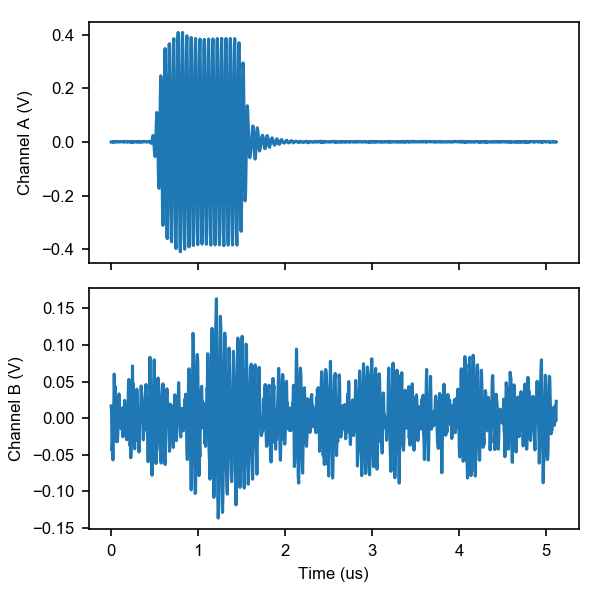

In [5]:
raw_acq.acq_time(5e-6)
raw_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                 buffers_per_acquisition=1,
                                 buffer_timeout=10000,
                                 allocated_buffers=1)
data = raw_acq.acquisition()

fig, (ax, bx) = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax.plot(raw_acq.tvals * 1e6, np.squeeze(data)[:, 0])
bx.plot(raw_acq.tvals * 1e6, np.squeeze(data)[:, 1])

ax.set_ylabel('Channel A (V)')
bx.set_ylabel('Channel B (V)')
bx.set_xlabel('Time (us)')

fig.tight_layout()

In [ ]:
raw_acq.handling_times

<IPython.core.display.Javascript object>


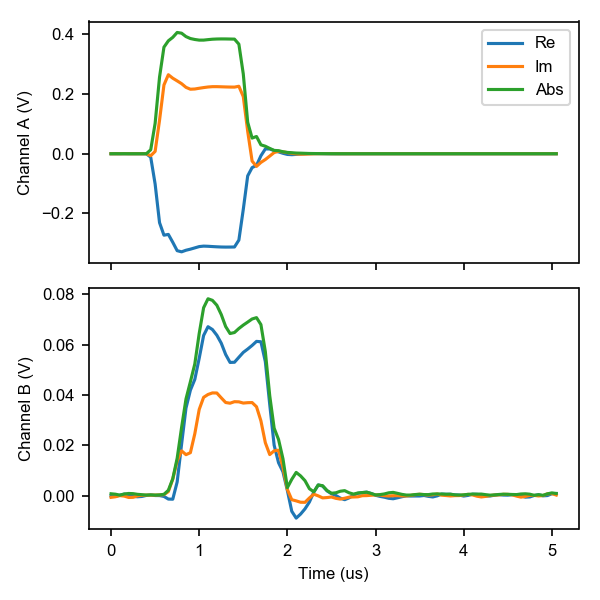

In [6]:
demod_acq.acq_time(5e-6)
demod_acq.demod_frq(20e6)
demod_acq.update_acquisitionkwargs(records_per_buffer=100, 
                                   buffers_per_acquisition=100,
                                   buffer_timeout=10000,
                                   allocated_buffers=1)
data = demod_acq.acquisition().mean(axis=0).mean(axis=0)

fig, (ax, bx) = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax.plot(demod_acq.demod_tvals * 1e6, np.squeeze(data)[:, 0].real, label='Re')
ax.plot(demod_acq.demod_tvals * 1e6, np.squeeze(data)[:, 0].imag, label='Im')
ax.plot(demod_acq.demod_tvals * 1e6, np.abs(np.squeeze(data)[:, 0]), label='Abs')
ax.legend()

bx.plot(demod_acq.demod_tvals * 1e6, np.squeeze(data)[:, 1].real)
bx.plot(demod_acq.demod_tvals * 1e6, np.squeeze(data)[:, 1].imag)
bx.plot(demod_acq.demod_tvals * 1e6, np.abs(np.squeeze(data)[:, 1]))

ax.set_ylabel('Channel A (V)')
bx.set_ylabel('Channel B (V)')
bx.set_xlabel('Time (us)')

fig.tight_layout()

In [ ]:
demod_acq.handling_times

<IPython.core.display.Javascript object>


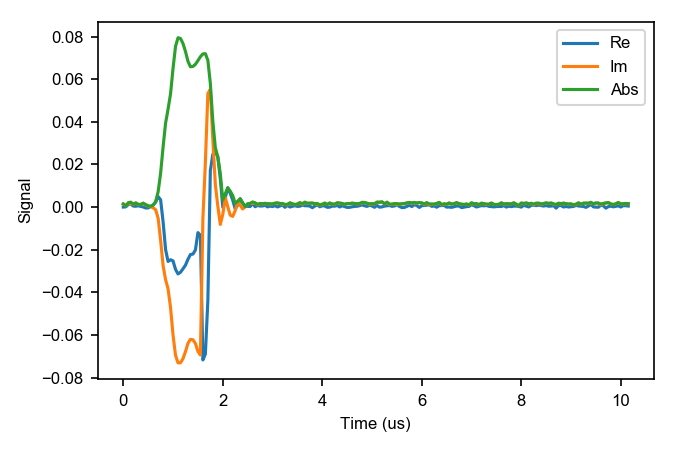

In [7]:
demodrel_acq.acq_time(10e-6)
demodrel_acq.demod_frq(20e6)
demodrel_acq.update_acquisitionkwargs(records_per_buffer=100, 
                                      buffers_per_acquisition=100,
                                      buffer_timeout=10000,
                                      allocated_buffers=1)
data = demodrel_acq.do_acquisition().mean(axis=0).mean(axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(demodrel_acq.demod_tvals * 1e6, np.squeeze(data).real, label='Re')
ax.plot(demodrel_acq.demod_tvals * 1e6, np.squeeze(data).imag, label='Im')
ax.plot(demodrel_acq.demod_tvals * 1e6, np.abs(np.squeeze(data)), label='Abs')
ax.legend()

ax.set_ylabel('Signal')
ax.set_xlabel('Time (us)')

fig.tight_layout()

In [ ]:
rel_acq.handling_times

<IPython.core.display.Javascript object>


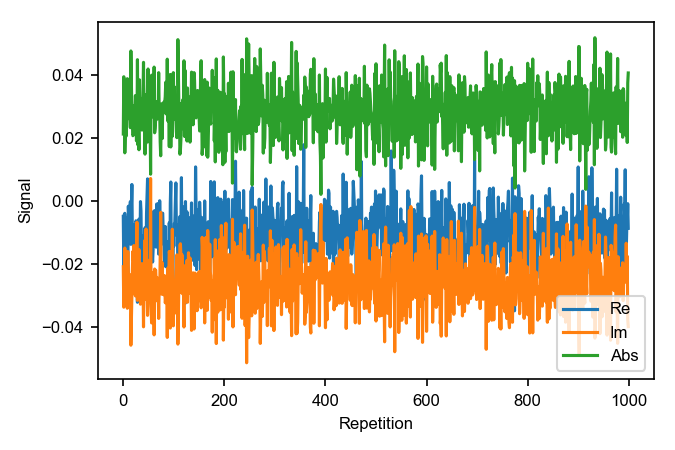

In [8]:
iqrel_acq.acq_time(2e-6)
iqrel_acq.demod_frq(20e6)
iqrel_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                   buffers_per_acquisition=1000,
                                   buffer_timeout=10000,
                                   allocated_buffers=1)
data = iqrel_acq.do_acquisition()
# print(data.shape, iqrel_acq.handling_times)

fig, ax = plt.subplots(1, 1)
ax.plot(np.squeeze(data).real, label='Re')
ax.plot(np.squeeze(data).imag, label='Im')
ax.plot(np.abs(np.squeeze(data)), label='Abs')
ax.legend()

ax.set_ylabel('Signal')
ax.set_xlabel('Repetition')

fig.tight_layout()